# Predict Drug Activity for Androgen Receptor

Adapted from Tomasz K. Piskorz. [Predict Drug activity for androgen receptor](https://github.com/tkpiskorz/cheminformatics_notebooks/blob/master/AR/Androgen%20receptor.ipynb).

## Overview

This tutorial demonstrates how to use machine learning algorithms to predict drug activity for androgen receptor using Quantitative Structure–Property Relationship (QSPR) descriptors. The analysis uses the Tox21 dataset and molecular descriptors calculated using the `mordred` package to build predictive models.

## Learning Objectives

- Learn how to work with chemical structure data using RDKit and `mordred`
- Understand how to calculate and use molecular descriptors for drug activity prediction 
- Build and evaluate machine learning models for drug activity classification
- Interpret model performance using ROC AUC scores and accuracy metrics

### Tasks to complete

Load and preprocess Tox21 dataset
Calculate molecular descriptors using mordred
Train and evaluate Random Forest model
Train and evaluate Neural Network model
Compare model performances

## Prerequisites

- A working Python environment and familiarity with Python
- Basic understanding of machine learning concepts
- Familiarity with pandas and numpy libraries
- Knowledge of basic statistical concepts

## Get Started

To start, we install required packages and import the necessary data and libraries.

### Install required packages

This tutorial uses a couple of packages we have not yet seen.  You can learn more about them here:

- RDKit: a Python [Open-Source Cheminformatics Software](https://www.rdkit.org/).
- mordred: a python [molecular descriptor calculator](https://github.com/mordred-descriptor/mordred) package.

In [1]:
# %pip install mordred numpy rdkit pandas scikit-learn

## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
from IPython.core.display import display
from mordred import Calculator, descriptors
from mordred.error import Missing
from rdkit import Chem

# Importing pandasTools enables several features that allow for using
# RDKit molecules as columns of a Pandas dataframe.
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

/tmp/ipykernel_44844/1573837776.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


## *Toxicology in the 21st Century* (Tox21) Dataset

The *Toxicology in the 21st Century* (Tox21) initiative created a public database measuring toxicity of compounds, which has been used in the 2014 Tox21 Data Challenge. This dataset contains qualitative toxicity measurements for 8k compounds on 12 different targets, including nuclear receptors and stress response pathways.

The data file contains a csv table, in which columns below are used:

- "smiles" - SMILES representation of the molecular structure
- "NR-XXX" - Nuclear receptor signaling bioassays results
  - [AR](https://pubchem.ncbi.nlm.nih.gov/bioassay/743040): qHTS assay to identify small molecule agonists of the androgen receptor (AR) signaling pathway using the MDA cell line.
  - [AhR](https://pubchem.ncbi.nlm.nih.gov/bioassay/743122): qHTS assay to identify small molecule that activate the aryl hydrocarbon receptor (AhR) signaling pathway.
  - [AR-LBD](https://pubchem.ncbi.nlm.nih.gov/bioassay/74353): qHTS assay to identify small molecule agonists of the androgen receptor (AR) signaling pathway.
 - [ER](https://pubchem.ncbi.nlm.nih.gov/bioassay/743079): qHTS assay to identify small molecule agonists of the estrogen receptor alpha (ER-alpha) signaling pathway using the BG1 cell line.
  - [ER-LBD](https://pubchem.ncbi.nlm.nih.gov/bioassay/743077): qHTS assay to identify small molecule agonists of the estrogen receptor alpha (ER-alpha) signaling pathway.
  - [aromatase](https://pubchem.ncbi.nlm.nih.gov/bioassay/743139): qHTS assay to identify aromatase inhibitors.
  - [PPAR-gamma](https://pubchem.ncbi.nlm.nih.gov/bioassay/743140): qHTS assay to identify small molecule agonists of the peroxisome proliferator-activated receptor gamma (PPARg) signaling pathway.

- "SR-XXX" - Stress response bioassays results
	- [ARE](https://pubchem.ncbi.nlm.nih.gov/bioassay/743219): qHTS assay for small molecule agonists of the antioxidant response element (ARE) signaling pathway.
	- [ATAD5](https://pubchem.ncbi.nlm.nih.gov/bioassay/720516): qHTS assay for small molecules that induce genotoxicity in human embryonic kidney cells expressing luciferase-tagged ATAD5.
	- [HSE](https://pubchem.ncbi.nlm.nih.gov/bioassay/743228): qHTS assay for small molecule activators of the heat shock response signaling pathway. 
	- [MMP](https://pubchem.ncbi.nlm.nih.gov/bioassay/720637): qHTS assay for small molecule disruptors of the mitochondrial membrane potential.
	- [p53](https://pubchem.ncbi.nlm.nih.gov/bioassay/720552): qHTS assay for small molecule agonists of the p53 signaling pathway.

Please refer to the links at https://tripod.nih.gov/tox21/challenge/data.jsp for details.

### References

Tox21 Challenge. https://tripod.nih.gov/tox21/challenge/

### Load Tox21 dataset

In [3]:
df = pd.read_csv("../../Data/tox21.csv")

In [4]:
# Show top 10 rows
df.head(10)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX6619,O=S(=O)(Cl)c1ccccc1
7,0.0,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,TOX25232,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX22514,OC[C@H](O)[C@@H](O)[C@H](O)CO
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX22517,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]


In [5]:
# Show descriptive summary statistics
df.describe()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
count,7265.000000,6758.000000,6549.000000,5821.000000,6193.000000,6955.000000,6450.000000,5832.000000,7072.000000,6467.000000,5810.000000,6774.000000
mean,0.042533,0.035070,0.117270,0.051538,0.128048,0.050324,0.028837,0.161523,0.037330,0.057523,0.158003,0.062445
std,0.201815,0.183969,0.321766,0.221110,0.334170,0.218627,0.167362,0.368044,0.189583,0.232857,0.364776,0.241979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Get column names
list(df.columns)

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53',
 'mol_id',
 'smiles']

In [7]:
# Get only 'NR-AR','smiles' columns
df = df[["NR-AR", "smiles"]]
df.head()

,NR-AR,smiles
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O


In [8]:
df.shape

(7831, 2)

In [9]:
# Converts the molecules contains in "smilesCol" to RDKit molecules and appends them to the
# dataframe "frame" using the specified column name.
# If desired, a fingerprint can be computed and stored with the molecule objects to accelerate
# substructure matching
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles")
df.head()

[15:02:22] WARNING: not removing hydrogen atom without neighbors


,NR-AR,smiles,ROMol
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f101db7b040>
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7f101db7b200>
2,NaN,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x7f101db7b6d0>
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,<rdkit.Chem.rdchem.Mol object at 0x7f101db7b120>
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7f101db7b740>


In [10]:
# Remove rows with missing values (NaN)
df = df[~df["ROMol"].isnull()]
df = df[~df["NR-AR"].isnull()]
df.shape

(7265, 3)

We can see 566 rows with missing values (NaN) are removed.

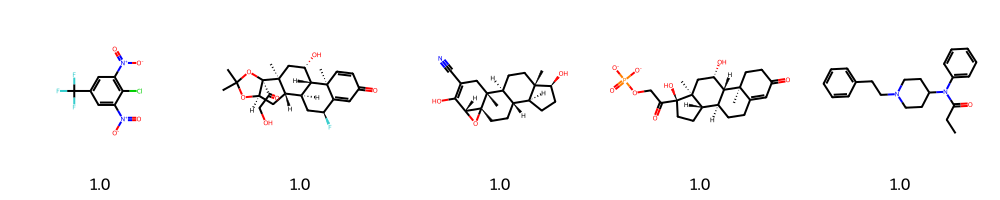

In [11]:
# Draw grid image of molecules in pandas DataFrame for 'NR-AR' of 1
display(
    PandasTools.FrameToGridImage(
        df[df["NR-AR"] == 1].head(5), legendsCol="NR-AR", molsPerRow=5
    )
)

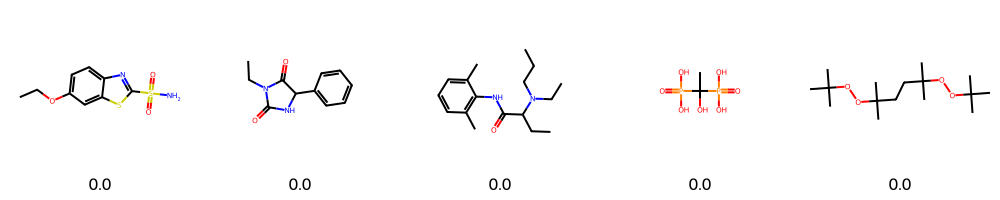

In [12]:
# Draw grid image of mols in pandas DataFrame for 'NR-AR' of 0
display(
    PandasTools.FrameToGridImage(
        df[df["NR-AR"] == 0].head(5), legendsCol="NR-AR", molsPerRow=5
    )
)

In [13]:
# Count number of distinct elements in 'NR-AR' column
df["NR-AR"].unique()

array([0., 1.])

In [14]:
# Count the total number of elements in 'NR-AR' column
df["NR-AR"].count()

7265

In [15]:
# Sum of the 'NR-AR' column
df["NR-AR"].sum()

309.0

## What is a molecular descriptor?

Molecular descriptors can be defined as mathematical representations of molecules’ properties that are generated by algorithms. The numerical values of molecular descriptors are used to quantitatively describe the physical and chemical information of the molecules. They can be used to predict the
activity, toxicity, and other properties resulting from the
chemical structures of compounds.

In [16]:
# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

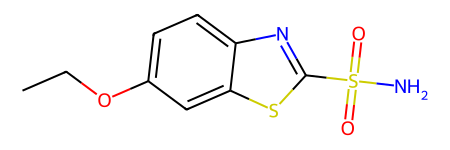

In [17]:
# Show the first molecule
mol = df["ROMol"][0]
mol

(The following step may take a few minutes to complete.)

In [18]:
# pandas method calculates multiple molecules, return pandas DataFrame
df2 = calc.pandas(df["ROMol"])

  1%|          | 44/7265 [00:01<03:09, 38.19it/s][15:02:25] WARNING: not removing hydrogen atom without neighbors
[15:02:25] WARNING: not removing hydrogen atom without neighbors
[15:02:25] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 7265/7265 [04:11<00:00, 28.93it/s]


In [19]:
df2.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12.395521,10.847181,0,0,19.462813,2.447713,4.716372,19.462813,1.216426,3.704694,...,9.698614,62.626045,258.013284,9.923588,442,22,84.0,97.0,6.256944,3.444444
1,11.370728,10.500427,0,0,19.28989,2.435261,4.703788,19.28989,1.285993,3.636116,...,9.553433,61.306823,204.089878,7.558884,353,22,76.0,90.0,5.305556,3.444444
3,14.308545,13.613603,0,1,24.388886,2.349426,4.698852,24.388886,1.219444,3.870393,...,9.653808,52.828148,276.220164,5.754587,830,30,92.0,105.0,8.666667,4.861111
4,8.152948,8.723360,4,0,10.363081,2.44949,4.898979,10.363081,0.942098,3.280313,...,9.682903,42.374286,205.974526,10.840765,136,18,56.0,64.0,8.1875,2.125000
5,15.024215,13.976628,0,0,20.871816,2.297773,4.595546,20.871816,1.043591,3.864202,...,9.674640,53.096806,290.245710,5.374921,934,21,98.0,100.0,11.75,4.000000


In [20]:
df2.shape

(7265, 1613)

In [21]:
# Find columns with known errored value

missing = []
for column in df2.columns:
    if (df2[column].apply(lambda x: type(x) == Missing)).any():
        missing.append(column)

In [22]:
# Drop columns with known errored value
df_new = df2.drop(missing, axis=1)

In [23]:
df_new.head()

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,12.395521,10.847181,0,0,9,10,26,16,0,0,...,6.861711,9.698614,62.626045,258.013284,9.923588,442,22,84.0,97.0,3.444444
1,11.370728,10.500427,0,0,6,6,27,15,0,0,...,7.002156,9.553433,61.306823,204.089878,7.558884,353,22,76.0,90.0,3.444444
3,14.308545,13.613603,0,1,6,6,48,20,0,0,...,0.000000,9.653808,52.828148,276.220164,5.754587,830,30,92.0,105.0,4.861111
4,8.152948,8.723360,4,0,0,0,19,11,0,0,...,0.000000,9.682903,42.374286,205.974526,10.840765,136,18,56.0,64.0,2.125000
5,15.024215,13.976628,0,0,0,0,54,20,0,0,...,0.000000,9.674640,53.096806,290.245710,5.374921,934,21,98.0,100.0,4.000000


In [24]:
df_new.shape

(7265, 687)

In [25]:
# Target
y = df["NR-AR"]

# Molecular descriptors
X = df_new

In [26]:
# Split data into 75% training and 25% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Random forest

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.


In [27]:
# Create a RandomForestClassifer with 100 trees in the forest.
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

### Receiver Operating Characteristic Curve (ROC AUC)

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predicted class probabilities

The predicted class probabilities of an input sample are computed as
the mean predicted class probabilities of the trees in the forest.

The class probability of a single tree is the fraction of samples of
the same class in a leaf.


In [28]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7829862666069562

In [29]:
# Compute the mean accuracy of training data
clf.score(X_train, y_train)

0.999632892804699

In [30]:
# Compute the mean accuracy of testing data
clf.score(X_test, y_test)

0.972482113373693

## Multi-layer Perceptron classifier

This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

In [31]:
print(X_train)

print(X_train.dropna())

            ABC      ABCGG  nAcid  nBase  nAromAtom  nAromBond  nAtom  \
5621  17.737138  14.840899      0      0          0          0     51   
1857  25.301424  19.838948      2      2         17         17     60   
1719   7.249407   6.952976      0      0          6          6     21   
6267  17.596789  13.936634      0      0          6          6     54   
6310   4.352030   4.798324      0      0          0          0     14   
...         ...        ...    ...    ...        ...        ...    ...   
2321   7.358797   6.909742      0      0          0          0     26   
1040  13.889167  12.874192      0      0          0          0     28   
2158  18.605421  15.128763      0      0         12         12     49   
7716  13.084601  11.426396      0      0         11         11     23   
2221   3.754314   4.057055      0      0          0          0     18   

      nHeavyAtom  nSpiro  nBridgehead  ...     SRW09      SRW10     TSRW10  \
5621          21       0            0  ...  8

(The following cell may take a few minutes to complete.)

In [32]:
# Create a Multi-layer Perceptron classifier with 6 hidden layers with corresponding number of neurons of
# 1000,500,250,100,50,20
clf = MLPClassifier(hidden_layer_sizes=[1000, 500, 250, 100, 50, 20]).fit(
    X_train, y_train
)

### Receiver Operating Characteristic Curve (ROC AUC)

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predicted class probabilities.

In [33]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.6349231228541574

In [34]:
# Compute the mean accuracy of testing data
clf.score(X_train, y_train)

0.9649412628487518

In [35]:
# Compute the mean accuracy of testing data
clf.score(X_test, y_test)

0.9581728123280132

## Conclusion

This tutorial demonstrated how to:

- Work with chemical structure data using RDKit
- Calculate molecular descriptors using `mordred`
- Build and evaluate machine learning models for predicting drug activity
- Use different model architectures (Random Forest and Neural Networks) for classification tasks
- Assess model performance using ROC AUC scores and accuracy metrics

## Clean up

Remember to shut down your Jupyter Notebook environment and delete any unnecessary files or resources once you've completed the tutorial.
